# Mercado Livre
## Challenge 3

## 1. Importação dos pacotes e funções

### 1.1 Bibliotecas utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score,f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn import model_selection
from IPython.display import display
import warnings
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 1.2 Configurações

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
sns.set_palette("gist_ncar")
sns.set_style("whitegrid")
seed = 42

In [3]:
def plot_ratio_horizontal(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        y = p.get_y() + p.get_height() / 2 + 0.12
        x = p.get_x() + p.get_width()
        ax.annotate(percentage, (x, y), size=13)
    plt.show()

In [4]:
def decil(x, df_ks):
    if df_ks['min_prob'][1] <= x <= 1:
        return 1
    else:
        for i in range(9):
            if df_ks['min_prob'][i+2] <= x < df_ks['min_prob'][(i+2-1)]:
                return i+2
    if x <= df_ks['min_prob'][10]:
        return 10

In [5]:
def ks(type = 'treino', data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    
    if type == 'treino':
        data['decil'] = pd.qcut(data[prob].rank(method = 'first'),10)
        
    grouped = data.groupby('decil', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    display(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [6]:
# esta função adiciona o valor relativo da categoria num gráfico de barras vertical
def plot_ratio(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=13)
    plt.show()

In [7]:
def correlated_columns(df, threshold):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
        .stack()
        .rename("kendall")
        .pipe(
            lambda s: s[
                s.abs() > threshold
            ].reset_index()
        )
        .query("level_0 not in level_1")
    )

In [8]:
def plot_confusion_matrix(y_train, y_test, X_train, X_test, model):
    #realiza a previsão de treino e teste
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    #calcula a acurácia de treino e teste
    acc_train = accuracy_score(y_pred_train, y_train) 
    acc_test = accuracy_score(y_pred_test, y_test) 
    #calcula a matriz de confusao de treino e teste
    cm_train = confusion_matrix(y_train, y_pred_train) 
    cm_test = confusion_matrix(y_test, y_pred_test) 
    #normaliza as matrizes de confusao
    cm_norm_train = cm_train / cm_train.astype(float).sum(axis=1)[:, np.newaxis]
    cm_norm_test = cm_test / cm_test.astype(float).sum(axis=1)[:, np.newaxis]
    #cria um dataframe com as matrizes de confusao
    cm_train_df = pd.DataFrame(cm_train,
                     index = ['0','1'], 
                     columns = ['0','1'])
    cm_test_df = pd.DataFrame(cm_test,
                     index = ['0','1'], 
                     columns = ['0','1'])
    cm_norm_train_df = pd.DataFrame(cm_norm_train,
                     index = ['0','1'], 
                     columns = ['0','1'])
    cm_norm_test_df = pd.DataFrame(cm_norm_test,
                     index = ['0','1'], 
                     columns = ['0','1'])
    #inicío do plot
    plt.figure(figsize=(10, 10))
    
    #subplot 1 (treino relativo)
    plt.subplot(2, 2, 1)
    sns.heatmap(cm_norm_train_df, annot=True,cmap='Blues', cbar = 0)
    plt.title('Train Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(acc_train))
    
    #subplot 2 (teste relativo)
    plt.subplot(2, 2, 2)
    sns.heatmap(cm_norm_test_df, annot=True,cmap='Blues', cbar = 0)
    plt.title('Test Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(acc_test))
    
    #subplot 1 (treino absoluto)
    plt.subplot(2, 2, 3)
    sns.heatmap(cm_train_df, annot=True,cmap='Blues', cbar = 0)
    plt.title('Train Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(acc_train))
    
    #subplot 2 (teste absoluto)
    plt.subplot(2, 2, 4)
    sns.heatmap(cm_test_df, annot=True,cmap='Blues', cbar = 0)
    plt.title('Test Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(acc_test))
    
    plt.tight_layout()
    plt.show()

In [9]:
def PROBA_DECIS(x,alta, media, baixa):
    if x['propensao'] >= alta:
        val = 'ALTA_PROPENSAO'
    elif x['propensao'] >= media:
        val = 'MEDIA_PROPENSAO'
    else:
        val = 'BAIXA_PROPENSAO'
    return val

In [10]:
# cria um gráfico com as matrizes de confusão de treino e de teste
def cf_plot(clf, X_train, X_test, y_train, y_test, method):
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train, normalize='true')
    cf_matrix_test = confusion_matrix(y_test, y_pred_test, normalize='true')
    disp_cf_matrix_train = ConfusionMatrixDisplay(
        cf_matrix_train)
    disp_cf_matrix_test = ConfusionMatrixDisplay(
        cf_matrix_test)
    f, axes = plt.subplots(1, 2, figsize=(15, 10), sharey='row')
    disp_cf_matrix_train.plot(ax=axes[0], cmap='Blues')
    disp_cf_matrix_train.ax_.set_xlabel(
        'Predicted label\naccuracy={:0.4f}'.format(acc_train)
                                        )
    disp_cf_matrix_test.plot(ax=axes[1], cmap='Blues')
    disp_cf_matrix_test.ax_.set_xlabel(
        'Predicted label\naccuracy={:0.4f}'.format(acc_test)
                                        )
    title_train = method+' (Train)'
    title_test = method+' (Test)'
    disp_cf_matrix_train.ax_.set_title(title_train)
    disp_cf_matrix_test.ax_.set_title(title_test)
    disp_cf_matrix_train.im_.colorbar.remove()
    disp_cf_matrix_test.im_.colorbar.remove()
    plt.show()

In [97]:
def models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=10, figsize = (20, 4)):
  results_cv = []
  results = []
  names = []
  best_sens_test = 0
  best_clf = ''
  best_name = ''
  for name, model in models:
    names.append(name)
    # cross validation
    kfold = model_selection.KFold(n_splits=n_splits)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results_cv.append(cv_results) # acc cv
    # model training
    time1 = datetime.datetime.now()
    model.fit(X_train, y_train)
    time2 = datetime.datetime.now()
    # model predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # accuracy
    train_acc = round(model.score(X_train,y_train),10)
    test_acc = round(model.score(X_test,y_test),10)
    #confusion matrix
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    #sensitivity
    sensitivity_train = tp_train/(tp_train+fn_train)
    sensitivity_test = tp_test/(tp_test+fn_test)
    if sensitivity_test >= best_sens_test:
        best_sens_test = round(sensitivity_test,10)
        best_clf = model
        best_name = name
    # training time
    duration=time2-time1
    # df
    results.append({'Name': name,
                    'CV Acc (train)': np.mean(cv_results),
                    'Accuracy (train)': train_acc,
                    'Accuracy (test)': test_acc,
                    'Train Acc Stability': np.abs(train_acc - np.mean(cv_results)),
                    'Train/Test Acc Stability': np.abs(test_acc - train_acc),
                    'Sensitivity (train)': round(sensitivity_train,10),
                    'Sensitivity (test)': round(sensitivity_test,10),
                    'Training time (s)': duration.total_seconds()})
  results_df = pd.DataFrame(results).sort_values(by='Sensitivity (test)', ascending=False).reset_index(drop = True)
  results_cv_df = pd.DataFrame(results_cv).T
  results_cv_df.columns = names
  print('----------------RESULTS-------------- \n')
  print('Best accuracy in train (CV mean): {:0.2f}'.format(np.max(np.mean(results_cv, axis=1))))
  print('Best accuracy in test: {:0.2f}'.format(results_df['Accuracy (test)'].max()))
  print('Best sensitivity in test: {:0.2f} \n'.format(results_df['Sensitivity (test)'].max()))
  print('\n-------------BEST CONFUSION MATRIX (SENSITIVITY TEST)----------- \n')
  cf_plot(best_clf, X_train, X_test, y_train, y_test, best_name)
  print('-----------MODELS COMPARISON--------- \n')
  display(results_df)
  print('\n-------------VIZUALIZATION----------- \n')
  comparison_visualization(results_cv_df, results_df, figsize)
  return results_cv_df, results_df

In [12]:
def comparison_visualization(results_cv_df, results_test, figsize = (20, 4)):
  fig, axs = plt.subplots(1, 2, figsize=figsize)
  sns.boxplot(data=results_cv_df.reindex(columns=list(results_test['Name'])), ax=axs[0]).set(xlabel='Algorithm', ylabel='Avg accuracy' )
  axs[0].title.set_text('Train CV accuracy results')
  sns.barplot(x = 'Name',y = 'Accuracy (test)', data = results_test, ax=axs[1]).set(xlabel='Algorithm', ylabel='Accuracy' )
  axs[1].title.set_text('Test accuracy results')
  plt.show()

## 2. Obtenção dos dados

### 2.1 Importação dos dados

In [13]:
data = pd.read_csv('full_devices.csv', encoding='latin1')

In [14]:
data.head() # exibindo as primeiras linhas

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [15]:
data.tail() # exibindo as últimas linhas

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


In [16]:
print('A base possui', data.shape[0], 'linhas e', data.shape[1], 'variáveis (atributos)')

A base possui 124494 linhas e 12 variáveis (atributos)


### 2.2 Análise de qualidade dos dados
#### 2.2.1 Tipo dos dados

In [17]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


#### 2.2.2 Valores únicos por variável

In [18]:
pd.options.display.max_rows = 118
print('Valores únicos em cada variável: \n')
data.nunique(dropna=False).sort_values()

Valores únicos em cada variável: 



failure            2
attribute7        28
attribute8        28
attribute3        47
attribute5        60
attribute9        65
attribute4       115
date             304
attribute2       558
device          1169
attribute6     44838
attribute1    123877
dtype: int64

#### 2.2.3 Valores ausentes

In [19]:
df_null = data.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("Colunas com valores ausentes (qtd relativa): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Colunas com valores ausentes (qtd relativa): 

Series([], dtype: float64)



## 3. Análise exploratória de dados

### 3.1 Estatística descritiva

In [20]:
data.drop(labels=['device'], axis=1).describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
failure,124494.00,0.00,0.03,0.00,0.00,0.00,0.00,1.00
attribute1,124494.00,122388103.24,70459334.22,0.00,61284762.00,122797388.00,183309640.00,244140480.00
attribute2,124494.00,159.48,2179.66,0.00,0.00,0.00,0.00,64968.00
attribute3,124494.00,9.94,185.75,0.00,0.00,0.00,0.00,24929.00
attribute4,124494.00,1.74,22.91,0.00,0.00,0.00,0.00,1666.00
attribute5,124494.00,14.22,15.94,1.00,8.00,10.00,12.00,98.00
attribute6,124494.00,260172.66,99151.08,8.00,221452.00,249799.50,310266.00,689161.00
attribute7,124494.00,0.29,7.44,0.00,0.00,0.00,0.00,832.00
attribute8,124494.00,0.29,7.44,0.00,0.00,0.00,0.00,832.00
attribute9,124494.00,12.45,191.43,0.00,0.00,0.00,0.00,18701.00


In [21]:
df_zeros = (data == 0).mean()
df_zeros = df_zeros[df_zeros > 0] * 100
print("Colunas com valores zero (qtd relativa): \n\n{}\n".format(df_zeros.sort_values(ascending = False)))

Colunas com valores zero (qtd relativa): 

failure       99.914855
attribute7    98.828859
attribute8    98.828859
attribute2    94.872042
attribute3    92.662297
attribute4    92.499237
attribute9    78.202966
attribute1     0.008836
dtype: float64



##### 3.1.1.1 Variáveis numéricas por variável resposta

In [22]:
df_1.drop(labels=['device'], axis=1).describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

NameError: name 'df_1' is not defined

In [ ]:
df_0.drop(labels=['device'], axis=1).describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

#### 3.1.3 Variável resposta

In [23]:
data['Target_hum'] = data.failure.map({0: 'Sem falha', 1: 'Falha'})

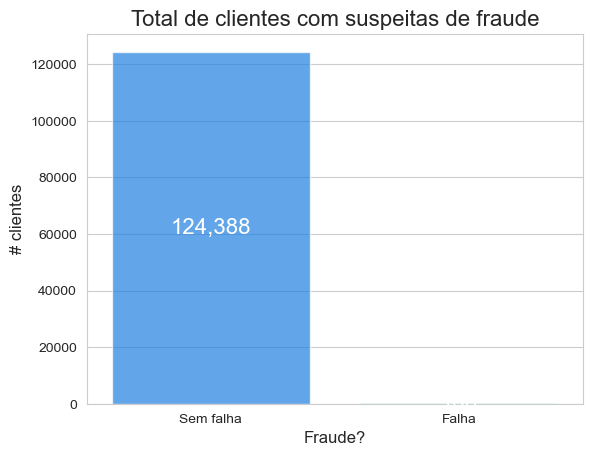

In [24]:
ax = sns.countplot(data=data, x='Target_hum', alpha=0.7)
plt.title('Total de clientes com suspeitas de fraude', fontsize=16)
plt.ylabel('# clientes', fontsize=12)
plt.xlabel('Fraude?', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
for p in ax.patches:
    ax.annotate('{0:,}'.format(p.get_height()), (p.get_x()+0.4, (p.get_height()/2)), ha='center', va='center', color='white', size=16)
plt.show()

In [25]:
print('% de clientes recusados pela Pagar.me com fraudes confirmadas')
data.Target_hum.value_counts()/data.shape[0] * 100

% de clientes recusados pela Pagar.me com fraudes confirmadas


Sem falha    99.914855
Falha         0.085145
Name: Target_hum, dtype: float64

In [26]:
data['failure_cumsum'] = data.groupby(['device'])['failure'].cumsum()
device_failure = data[data['failure_cumsum'] > 0]

In [27]:
data_failure = data[data['failure'] == 1]

In [28]:
data_healthy = data[data['failure'] == 0]

In [29]:
data_healthy.shape

(124388, 14)

In [30]:
data_failure.shape

(106, 14)

In [31]:
device_failure.shape

(153, 14)

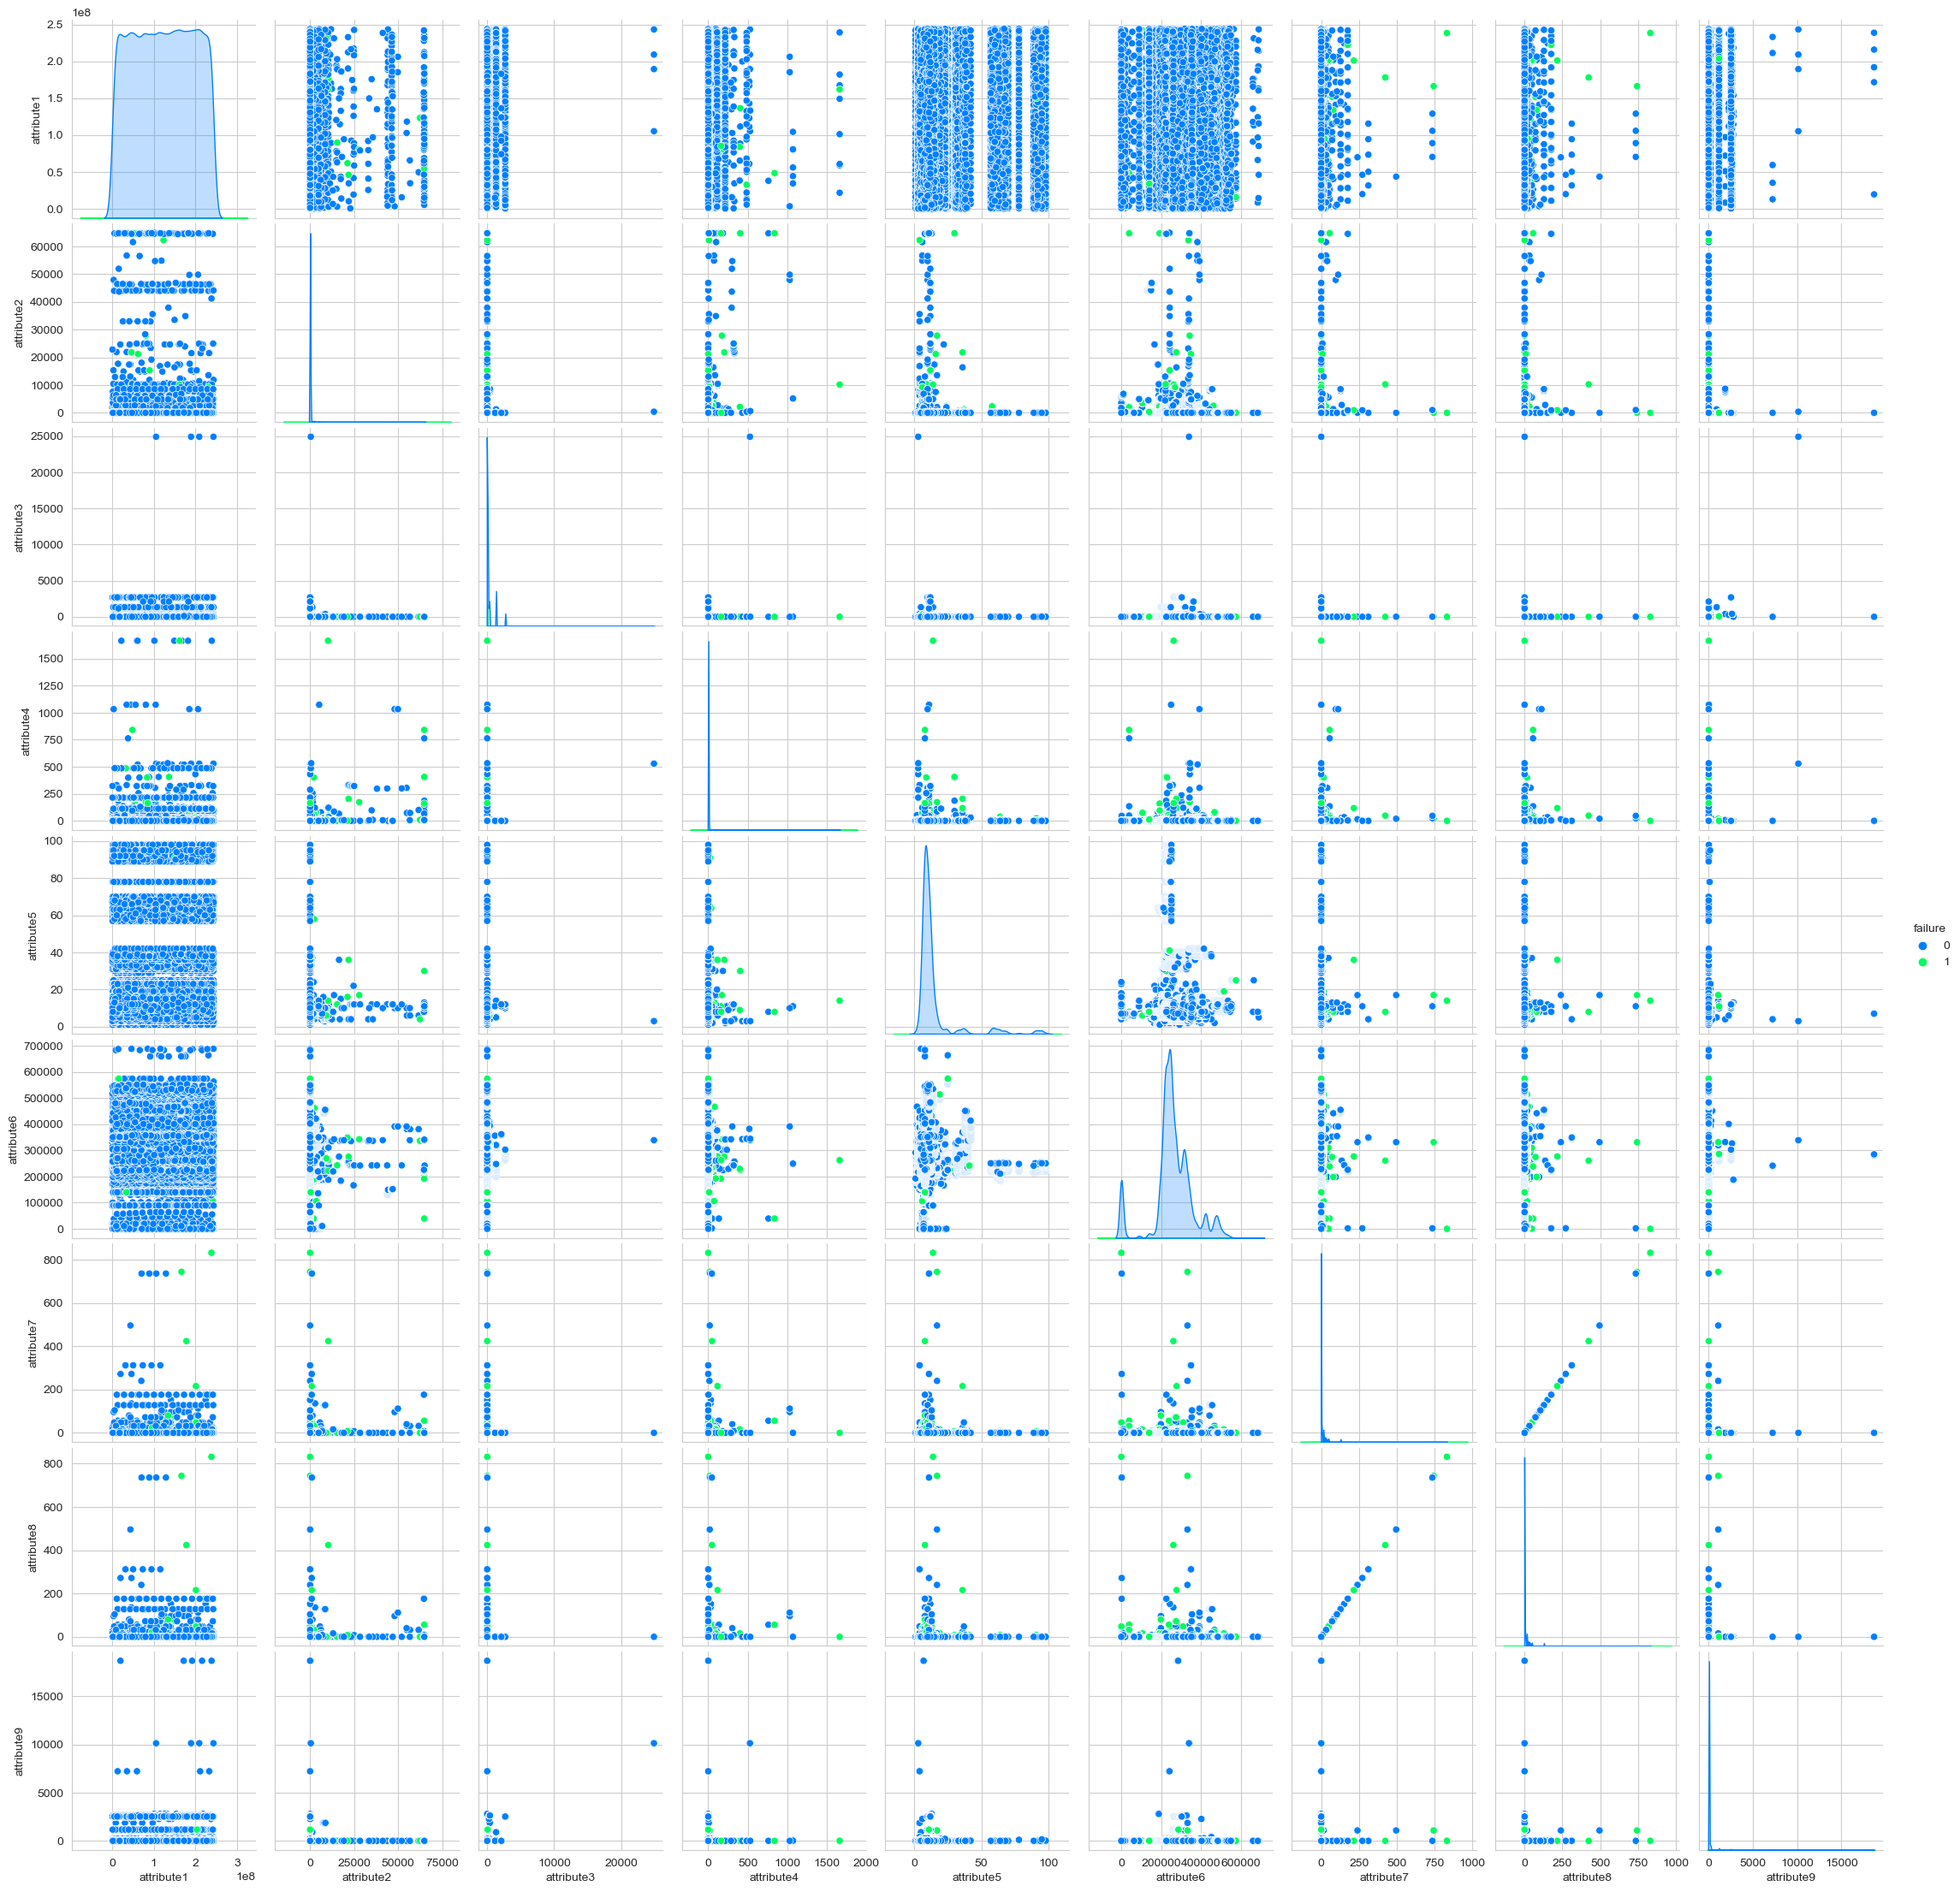

In [32]:
numeric_cols = ['device','failure','attribute1', 'attribute2','attribute3', 'attribute4','attribute5','attribute6','attribute7','attribute8','attribute9', 'date']
sns.pairplot(data[numeric_cols], hue = 'failure')
plt.show()

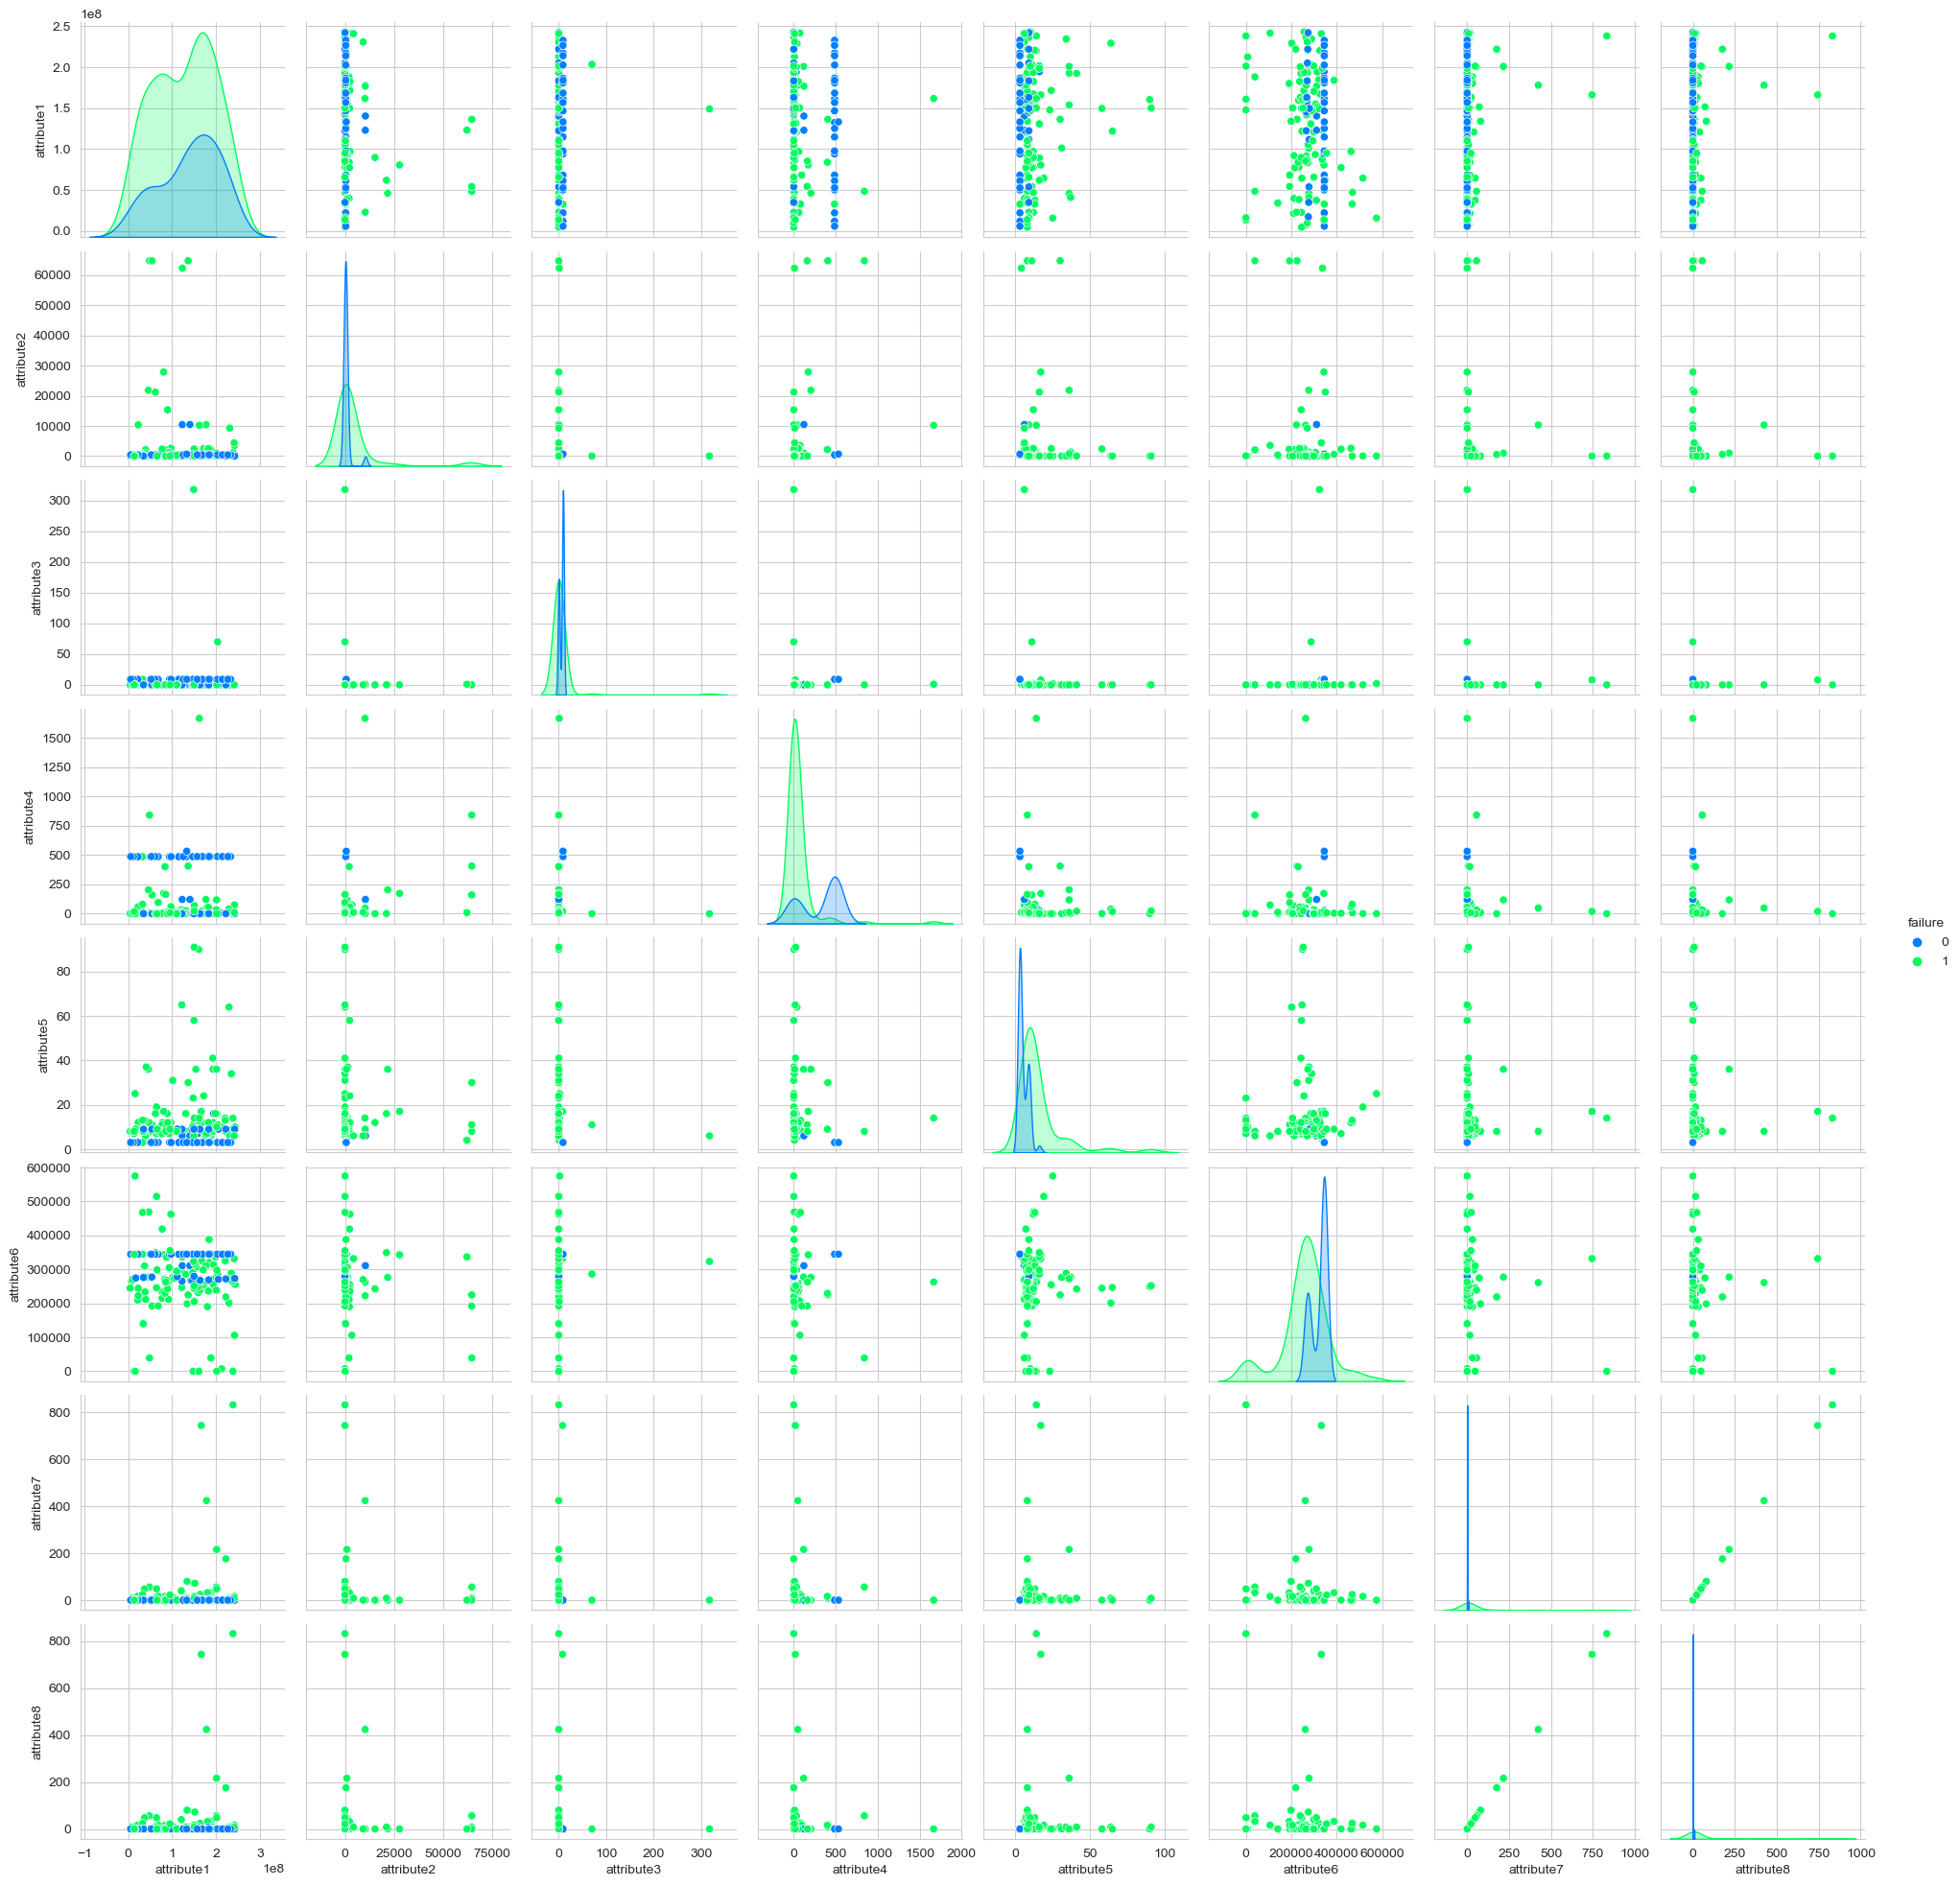

In [36]:
numeric_cols = ['device','failure','attribute1', 'attribute2','attribute3', 'attribute4','attribute5','attribute6','attribute7','attribute8']
sns.pairplot(device_failure[numeric_cols], hue = 'failure')
plt.show()

### Falta ver como a data se comporta dos produtos que falharam

In [33]:
const_columns = list(data.columns[data.nunique(dropna=False) <= 1])
print(const_columns)

[]


In [34]:
all_columns = list(data.columns)
print(all_columns)

['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9', 'Target_hum', 'failure_cumsum']


In [35]:
used_columns = [x for x in all_columns if (x not in const_columns)]
print(used_columns)

['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9', 'Target_hum', 'failure_cumsum']


# Normalização

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## 4. Separação entre treino e teste

In [64]:
# divide a base em partições de treino (70%) e teste (30%) com dados estratificados pela variável alvo
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['device','failure','Target_hum','date'], axis=1), 
    data['failure'], 
    test_size=0.3, 
    random_state=42, 
    stratify=data['failure'])

print("Número de registros em X_train: ", X_train.shape)
print("Número de registros em y_train: ", y_train.shape)
print("Número de registros em X_test: ", X_test.shape)
print("Número de registros em y_test: ", y_test.shape)

Número de registros em X_train:  (87145, 10)
Número de registros em y_train:  (87145,)
Número de registros em X_test:  (37349, 10)
Número de registros em y_test:  (37349,)


In [65]:
data_train = X_train.join(y_train)

In [66]:
data_test = X_test.join(y_test)

In [67]:
data_train.shape

(87145, 11)

In [68]:
data_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87145 entries, 89540 to 1901
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attribute1      87145 non-null  float64
 1   attribute2      87145 non-null  float64
 2   attribute3      87145 non-null  float64
 3   attribute4      87145 non-null  float64
 4   attribute5      87145 non-null  float64
 5   attribute6      87145 non-null  float64
 6   attribute7      87145 non-null  float64
 7   attribute8      87145 non-null  float64
 8   attribute9      87145 non-null  float64
 9   failure_cumsum  87145 non-null  float64
 10  failure         87145 non-null  float64
dtypes: float64(11)
memory usage: 10.0 MB


In [69]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)

In [70]:
X_under, y_under = undersample.fit_resample(X_train, y_train)

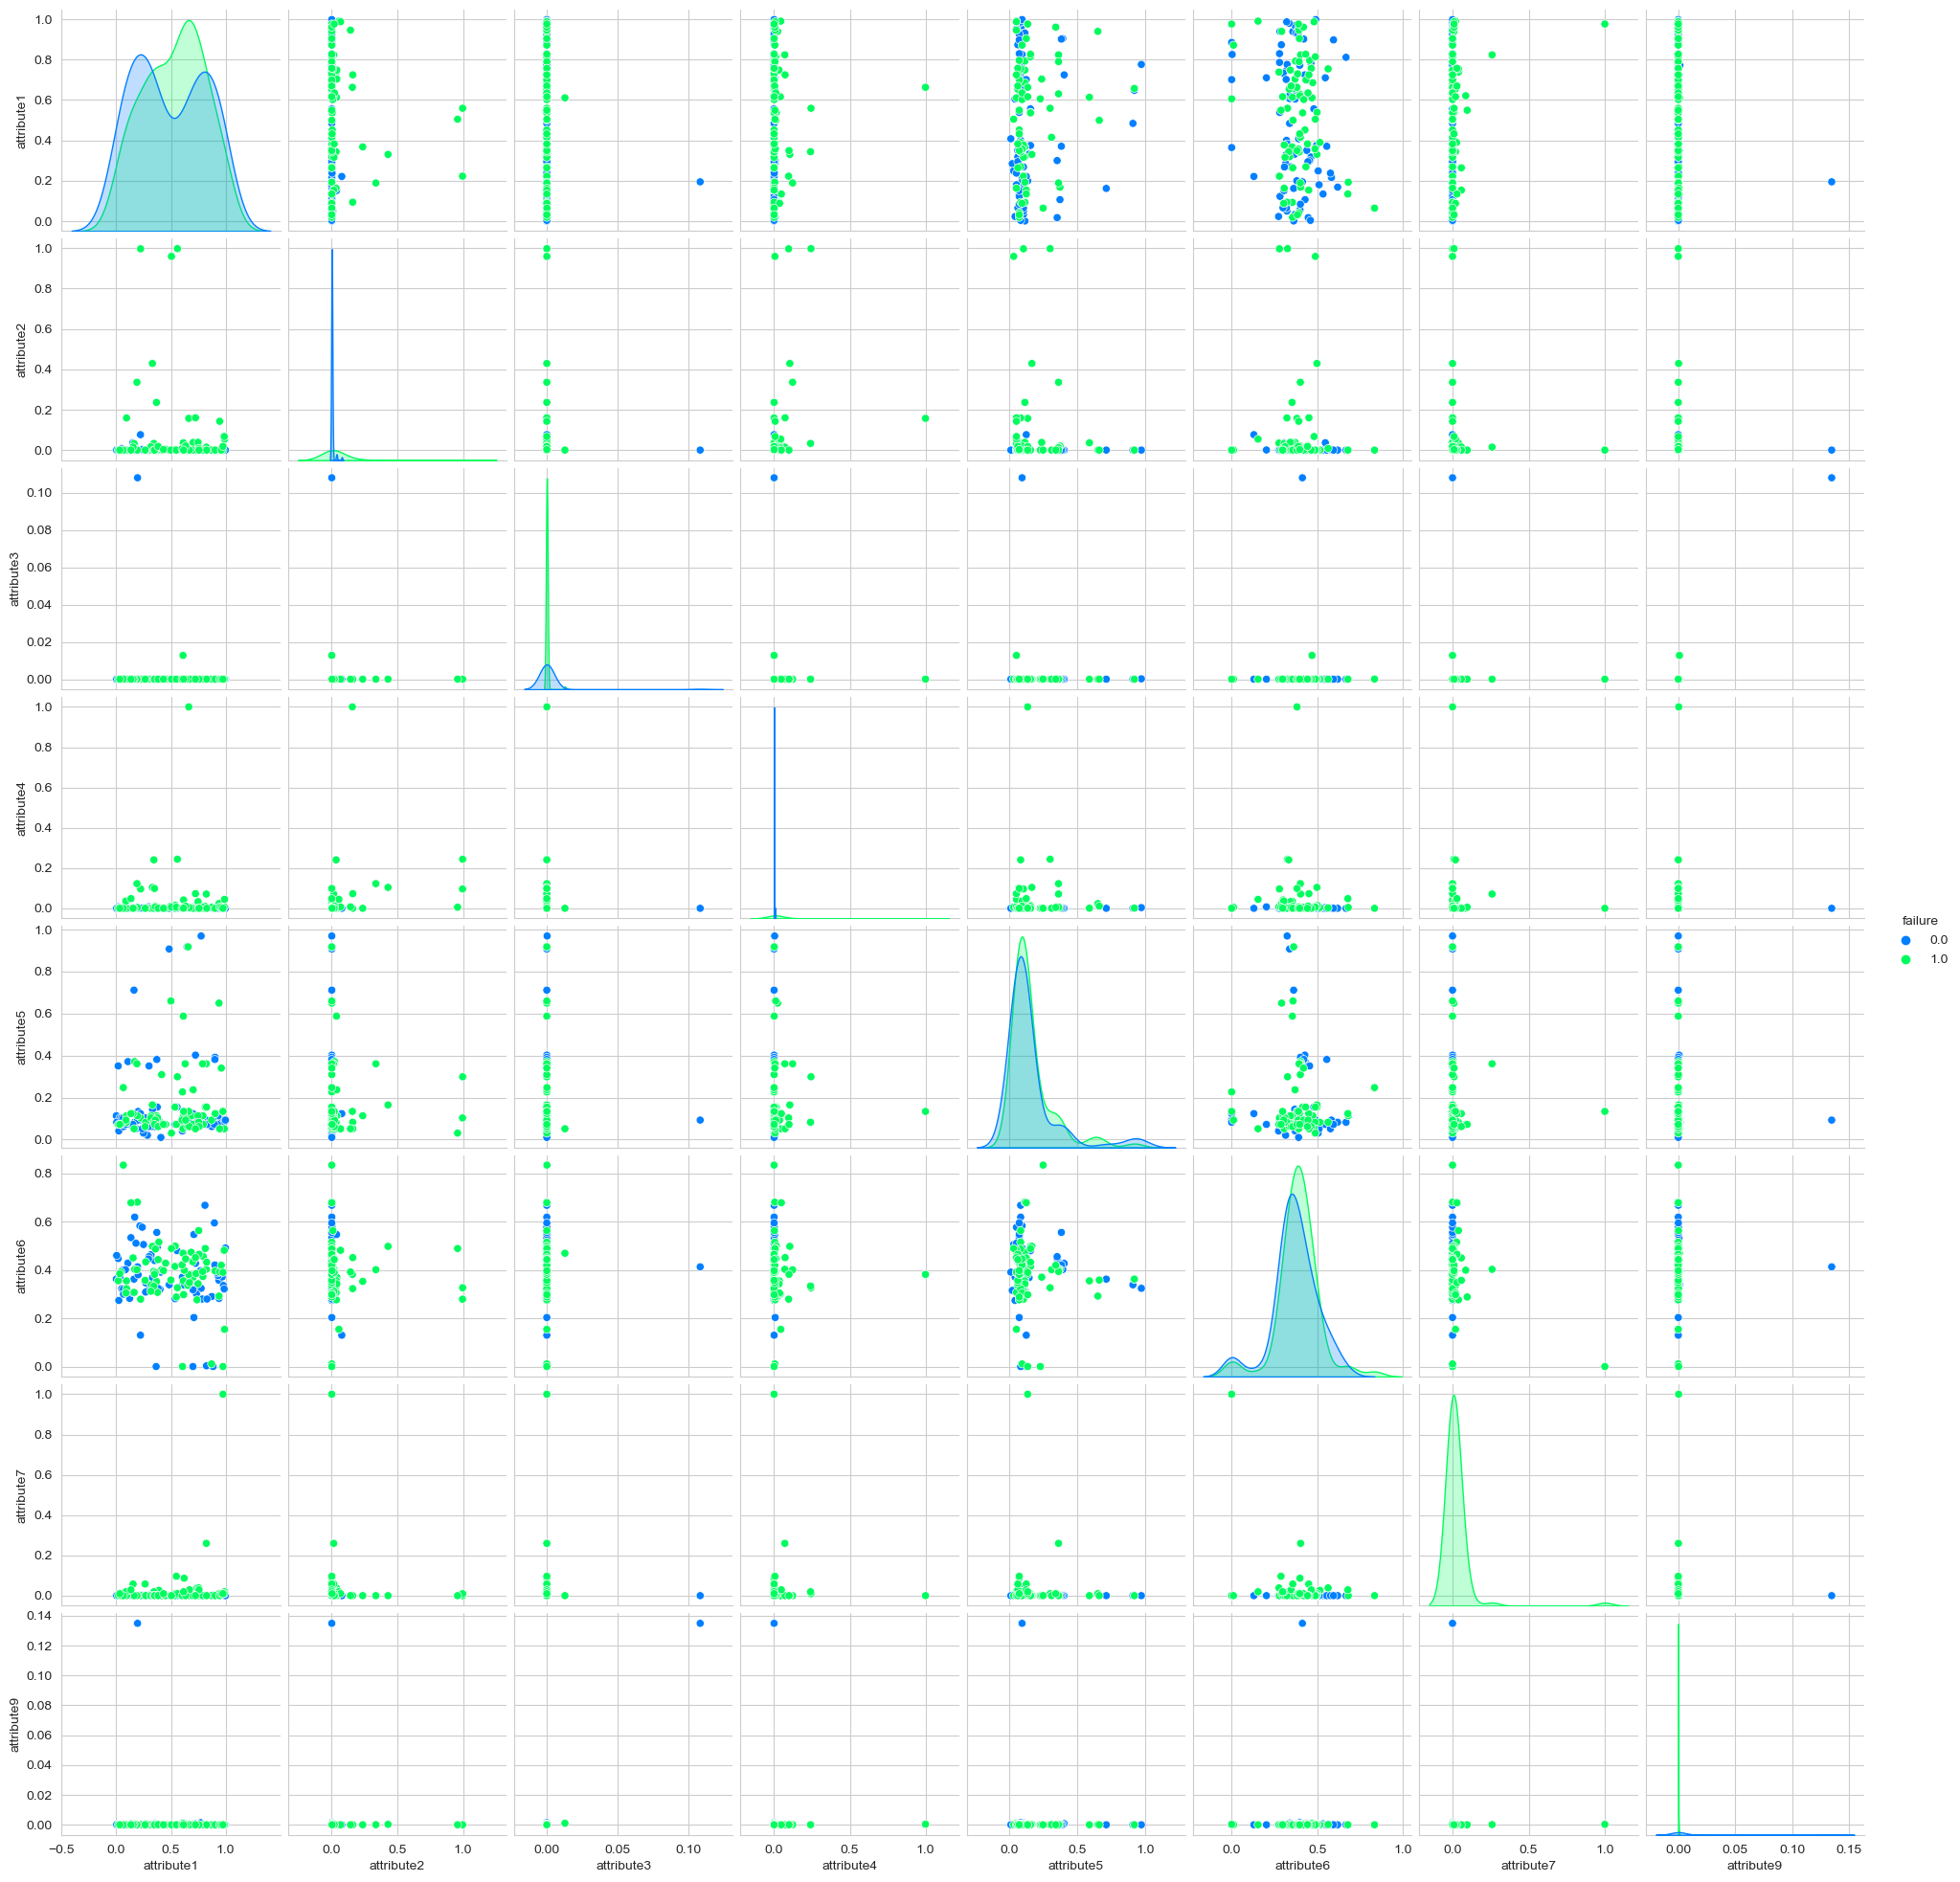

In [43]:
data_under=pd.DataFrame(X_under)
data_under['failure']=pd.DataFrame(y_under)['failure']
numeric_cols = ['failure','attribute1', 'attribute2','attribute3', 'attribute4','attribute5','attribute6','attribute7','attribute9', 'date']
sns.pairplot(data_under[numeric_cols], hue = 'failure')
plt.show()

In [71]:
smote = SMOTE(sampling_strategy='majority', random_state = 42)

In [72]:
X_smote, y_smote = undersample.fit_resample(X_train, y_train)

## 5. Análise de correlação

### 5.1 Correlação com a variável target

In [73]:
data_corr = data_train.corr(method='kendall')['failure'][:]
pd.DataFrame(data_corr).sort_values(by="failure", ascending = False)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5215: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5216: RuntimeWarning: invalid value encountered in sqrt
  z = con_minus_dis / np.sqrt(var)


,failure
failure,1.000000
failure_cumsum,0.809057
attribute7,0.089389
attribute8,0.089389
attribute4,0.055500
attribute2,0.054735
attribute5,0.005908
attribute6,0.003365
attribute1,0.002062
attribute9,0.001850


### 5.2 Multicolinariedade

<AxesSubplot:>

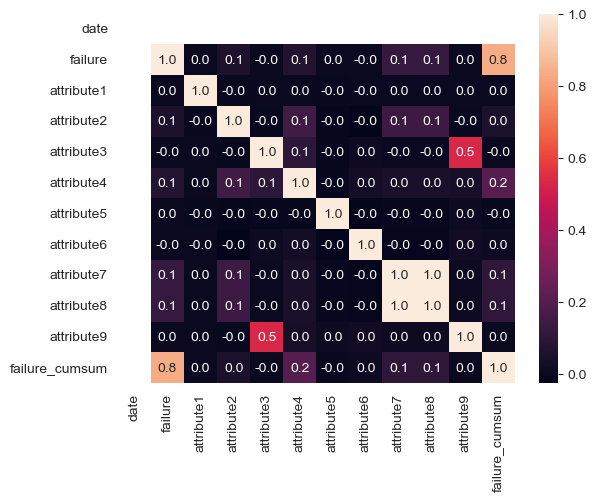

In [74]:
sns.heatmap(data.corr(), annot = True, fmt = ".1f")

In [75]:
X_train.drop(labels=['attribute8'], axis = 1, inplace = True)
X_test.drop(labels=['attribute8'], axis = 1, inplace = True)
X_under.drop(labels=['attribute8'], axis = 1, inplace = True)
X_smote.drop(labels=['attribute8'], axis = 1, inplace = True)
X_train.drop(labels=['failure_cumsum'], axis = 1, inplace = True)
X_test.drop(labels=['failure_cumsum'], axis = 1, inplace = True)
X_under.drop(labels=['failure_cumsum'], axis = 1, inplace = True)
X_smote.drop(labels=['failure_cumsum'], axis = 1, inplace = True)


## 6. Definição do sampling

## 6. Modelagem estatística

### 6.1  Seleção de modelos com todas as variáveis e undersampling

#### 6.1.1 Decision Tree

In [99]:
models = []
models.append(('DT 03', DecisionTreeClassifier(random_state=seed, max_depth = 3)))
models.append(('DT 04', DecisionTreeClassifier(random_state=seed, max_depth = 4)))
models.append(('DT 05', DecisionTreeClassifier(random_state=seed, max_depth = 5)))
models.append(('DT 06', DecisionTreeClassifier(random_state=seed, max_depth = 6)))
models.append(('DT 07', DecisionTreeClassifier(random_state=seed, max_depth = 7)))
models.append(('DT 08', DecisionTreeClassifier(random_state=seed, max_depth = 8)))
models.append(('DT 09', DecisionTreeClassifier(random_state=seed, max_depth = 9)))
models.append(('DT 10', DecisionTreeClassifier(random_state=seed, max_depth = 10)))
models.append(('DT 11', DecisionTreeClassifier(random_state=seed, max_depth = 11)))
models.append(('DT 12', DecisionTreeClassifier(random_state=seed, max_depth = 12)))
models.append(('DT 13', DecisionTreeClassifier(random_state=seed, max_depth = 13)))
models.append(('DT 20', DecisionTreeClassifier(random_state=seed, max_depth = 20)))

----------------RESULTS-------------- 

Best accuracy in train (CV mean): 0.71
Best accuracy in test: 0.96
Best sensitivity in test: 0.75 


-------------BEST CONFUSION MATRIX (SENSITIVITY TEST)----------- 



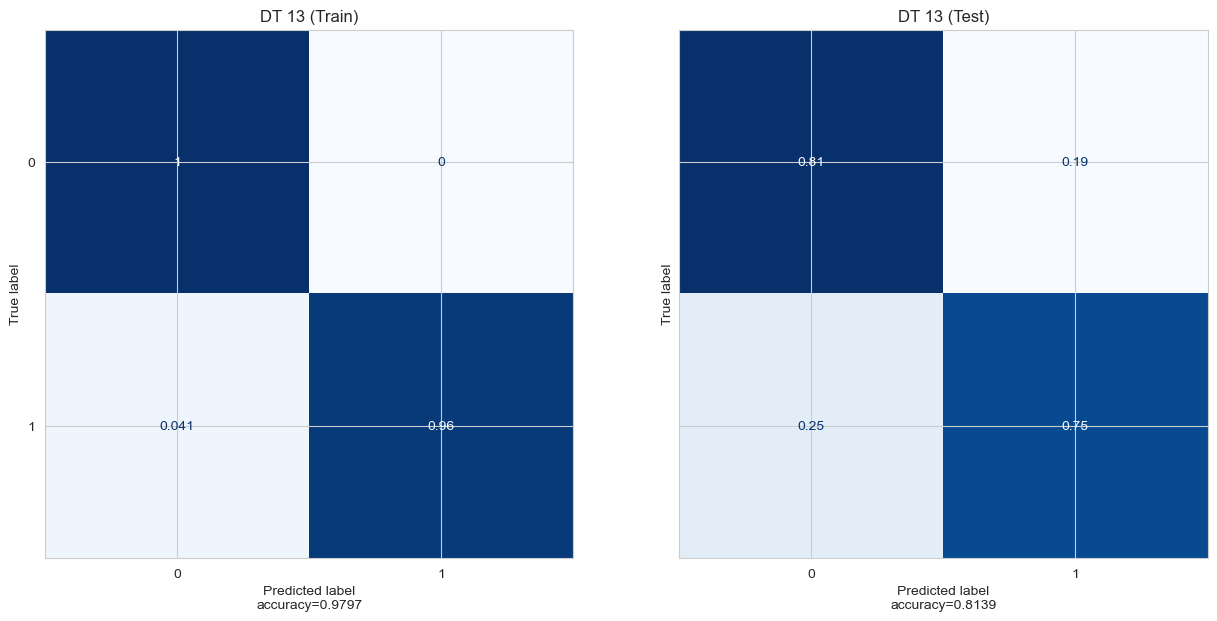

-----------MODELS COMPARISON--------- 



,Name,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Sensitivity (train),Sensitivity (test),Training time (s)
0,DT 13,0.614713,0.979730,0.813891,0.365017,0.165839,0.959459,0.75000,0.000160
1,DT 11,0.587356,0.959459,0.838844,0.372103,0.120615,0.918919,0.71875,0.000000
2,DT 08,0.620920,0.925676,0.893009,0.304756,0.032666,0.851351,0.65625,0.001009
3,DT 20,0.594023,1.000000,0.742911,0.405977,0.257089,1.000000,0.65625,0.000000
4,DT 03,0.680230,0.837838,0.944845,0.157608,0.107007,0.756757,0.62500,0.015637
5,DT 04,0.714483,0.851351,0.952234,0.136869,0.100883,0.756757,0.62500,0.000000
6,DT 07,0.667586,0.912162,0.925219,0.244576,0.013057,0.824324,0.62500,0.000992
7,DT 09,0.594253,0.925676,0.902702,0.331423,0.022974,0.851351,0.62500,0.000000
8,DT 10,0.594253,0.932432,0.663150,0.338180,0.269282,0.986486,0.62500,0.000999
9,DT 12,0.600920,0.966216,0.685159,0.365297,0.281057,1.000000,0.62500,0.001001



-------------VIZUALIZATION----------- 



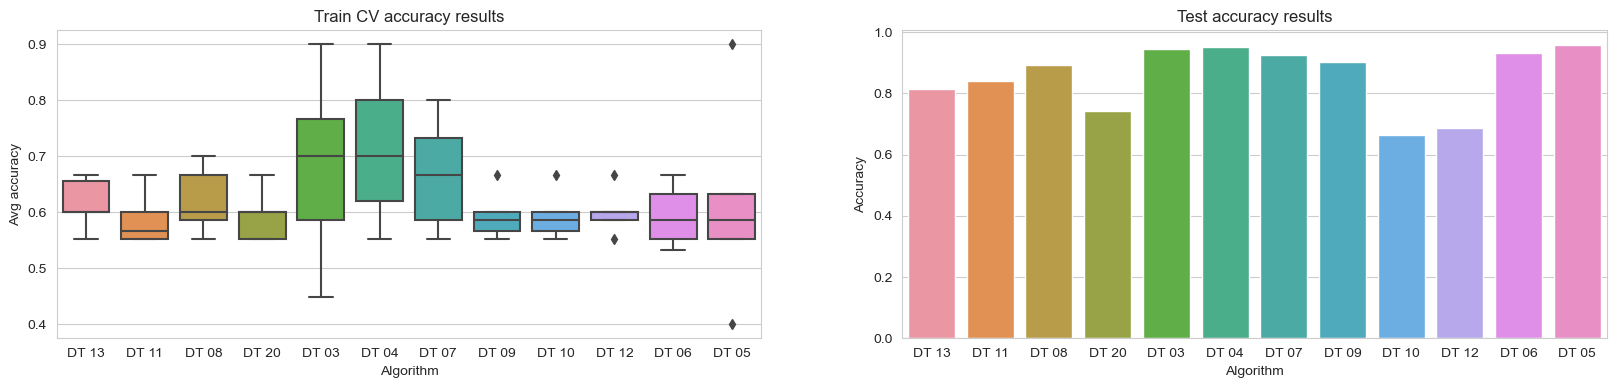

In [100]:
a,b = models_score(models, X_under, y_under, X_test, y_test, scoring = 'accuracy', n_splits=5)

#### 6.1.2 Random Forest

In [101]:
models = []
models.append(('RF 03', RandomForestClassifier(random_state=seed, max_depth = 3, n_jobs=4)))
models.append(('RF 04', RandomForestClassifier(random_state=seed, max_depth = 4, n_jobs=4)))
models.append(('RF 05', RandomForestClassifier(random_state=seed, max_depth = 5, n_jobs=4)))
models.append(('RF 06', RandomForestClassifier(random_state=seed, max_depth = 7, n_jobs=4)))
models.append(('RF 07', RandomForestClassifier(random_state=seed, max_depth = 7, n_jobs=4)))
models.append(('RF 08', RandomForestClassifier(random_state=seed, max_depth = 8, n_jobs=4)))
models.append(('RF 09', RandomForestClassifier(random_state=seed, max_depth = 9, n_jobs=4)))
models.append(('RF 10', RandomForestClassifier(random_state=seed, max_depth = 10, n_jobs=4)))
models.append(('RF 11', RandomForestClassifier(random_state=seed, max_depth = 11, n_jobs=4)))
models.append(('RF 12', RandomForestClassifier(random_state=seed, max_depth = 12, n_jobs=4)))
models.append(('RF 13', RandomForestClassifier(random_state=seed, max_depth = 13, n_jobs=4)))
models.append(('RF 20', RandomForestClassifier(random_state=seed, max_depth = 20, n_jobs=4)))

----------------RESULTS-------------- 

Best accuracy in train (CV mean): 0.69
Best accuracy in test: 0.94
Best sensitivity in test: 0.69 


-------------BEST CONFUSION MATRIX (SENSITIVITY TEST)----------- 



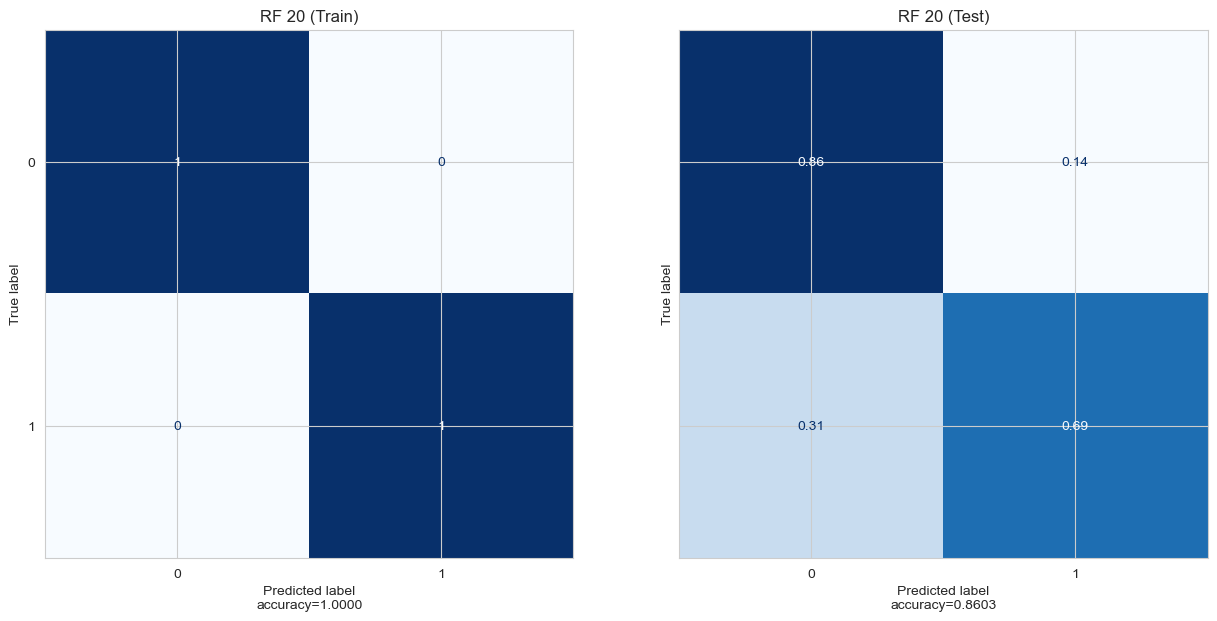

-----------MODELS COMPARISON--------- 



,Name,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Sensitivity (train),Sensitivity (test),Training time (s)
0,RF 11,0.662759,1.000000,0.864735,0.337241,0.135265,1.000000,0.68750,0.244345
1,RF 12,0.649195,1.000000,0.866235,0.350805,0.133765,1.000000,0.68750,0.251550
2,RF 13,0.655862,1.000000,0.864334,0.344138,0.135666,1.000000,0.68750,0.273301
3,RF 20,0.655862,1.000000,0.860318,0.344138,0.139682,1.000000,0.68750,0.287284
4,RF 04,0.675172,0.878378,0.934643,0.203206,0.056265,0.770270,0.65625,0.259264
5,RF 06,0.675862,0.939189,0.917454,0.263327,0.021735,0.878378,0.65625,0.254377
6,RF 07,0.675862,0.939189,0.917454,0.263327,0.021735,0.878378,0.65625,0.257332
7,RF 08,0.662529,0.966216,0.901390,0.303687,0.064827,0.932432,0.65625,0.273098
8,RF 09,0.655862,0.986486,0.880693,0.330624,0.105794,0.972973,0.65625,0.198197
9,RF 10,0.655862,1.000000,0.875659,0.344138,0.124341,1.000000,0.65625,0.246056



-------------VIZUALIZATION----------- 



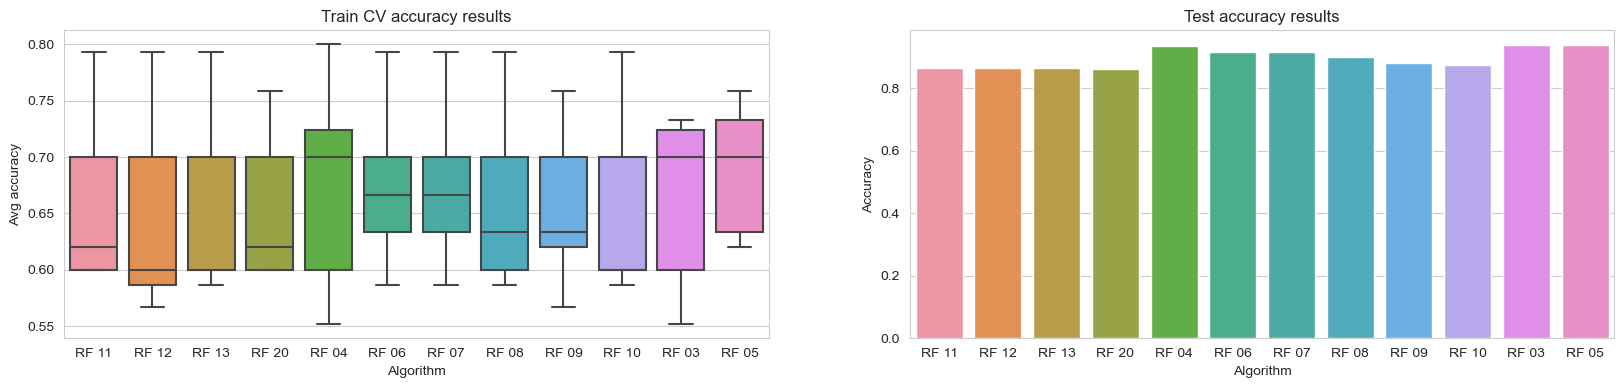

In [102]:
a,b = models_score(models, X_under, y_under, X_test, y_test, scoring = 'accuracy', n_splits=5)

#### 6.1.3 Vários modelos

In [103]:
models = []
models.append(('LR', LogisticRegression(random_state=seed, solver = 'saga')))
models.append(('DT', DecisionTreeClassifier(random_state=seed, max_depth = 4)))
models.append(('ADA', AdaBoostClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, max_depth = 7, n_jobs=4)))
models.append(('XGB', XGBClassifier(random_state=seed, eval_metric='logloss', n_jobs=-1, use_label_encoder=False)))
models.append(('MLP', MLPClassifier(random_state=seed, max_iter=500)))
models.append(('GB', GradientBoostingClassifier(random_state=seed)))
models.append(('ET', ExtraTreesClassifier(random_state=seed, n_jobs=-1)))

## 6.1 Imbalanced

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

----------------RESULTS-------------- 

Best accuracy in train (CV mean): 1.00
Best accuracy in test: 1.00
Best sensitivity in test: 0.09 


-------------BEST CONFUSION MATRIX (SENSITIVITY TEST)----------- 



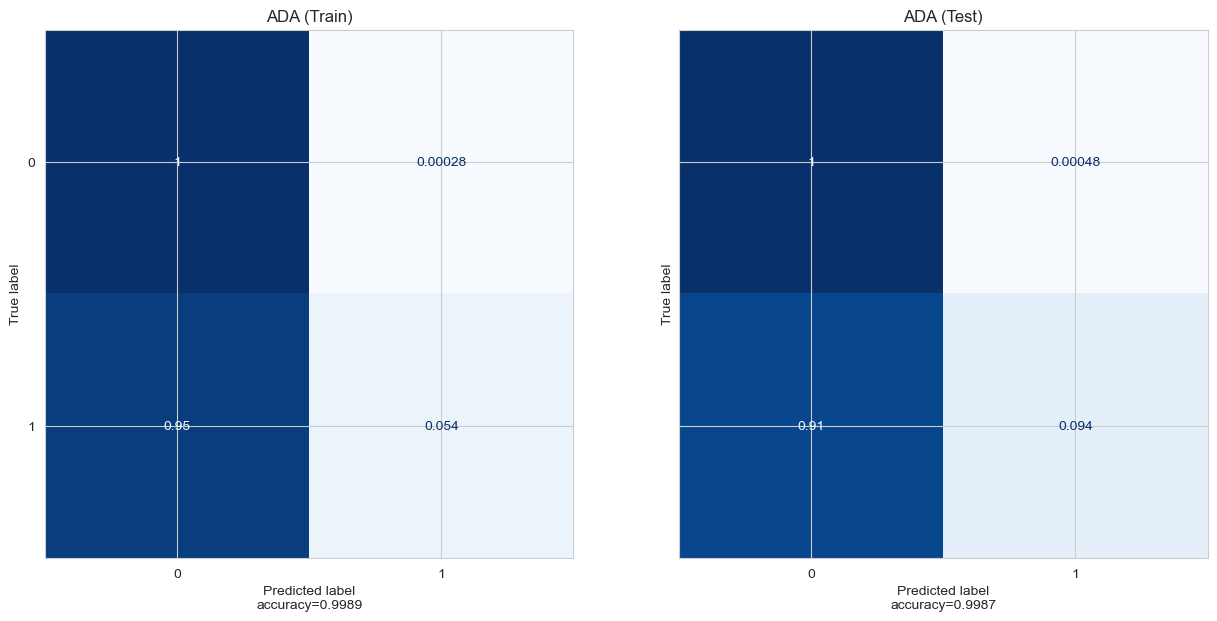

-----------MODELS COMPARISON--------- 



,Name,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Sensitivity (train),Sensitivity (test),Training time (s)
0,ADA,0.998887,0.998921,0.998742,3.442538e-05,0.000180,0.054054,0.09375,2.402118
1,LR,0.999151,0.999151,0.999143,4.689893e-11,0.000008,0.000000,0.00000,0.345989
2,DT,0.999071,0.999185,0.999116,1.147512e-04,0.000069,0.040541,0.00000,0.110373
3,RF,0.999139,0.999174,0.999143,3.442537e-05,0.000031,0.027027,0.00000,1.162451
4,XGB,0.999059,0.999782,0.999063,7.229331e-04,0.000719,0.743243,0.00000,2.750024
5,MLP,0.999139,0.999151,0.999143,1.147517e-05,0.000008,0.000000,0.00000,12.043018
6,GB,0.998979,0.999208,0.999063,2.295026e-04,0.000145,0.108108,0.00000,8.856189
7,ET,0.999036,0.999989,0.998983,9.524356e-04,0.001006,0.986486,0.00000,0.800047



-------------VIZUALIZATION----------- 



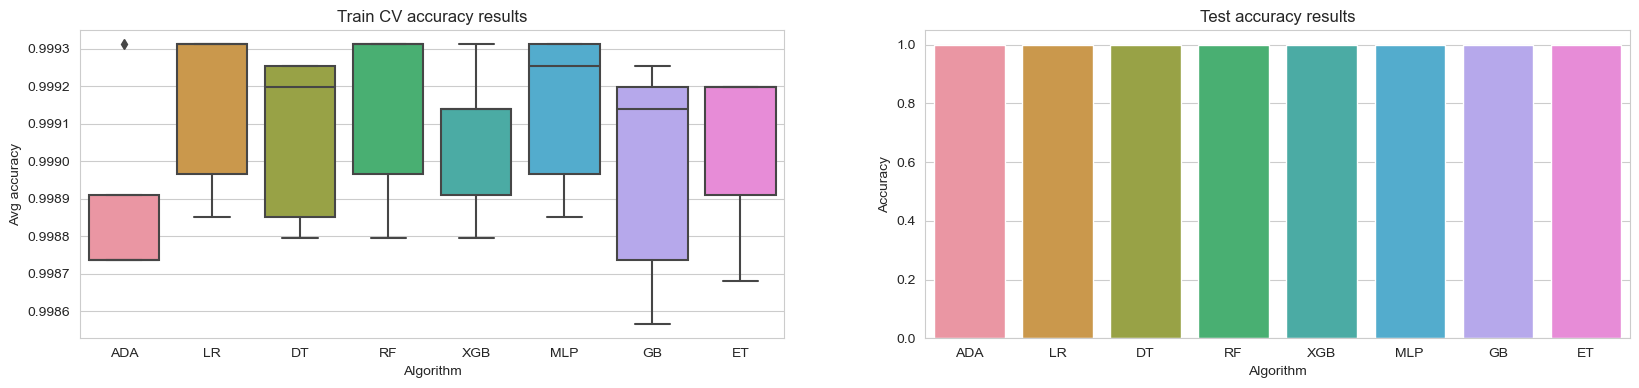

In [107]:
a,b = models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=5)

### Dados desbalanceados causaram um overfitting, classificando tudo no teste como caso sem falha. O que é um problema para o nosso caso, onde querems prever uma manutenção preventiva para minimizar os custos.

## 6.2 Undersampling

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

----------------RESULTS-------------- 

Best accuracy in train (CV mean): 0.71
Best accuracy in test: 0.95
Best sensitivity in test: 0.72 


-------------BEST CONFUSION MATRIX (SENSITIVITY TEST)----------- 



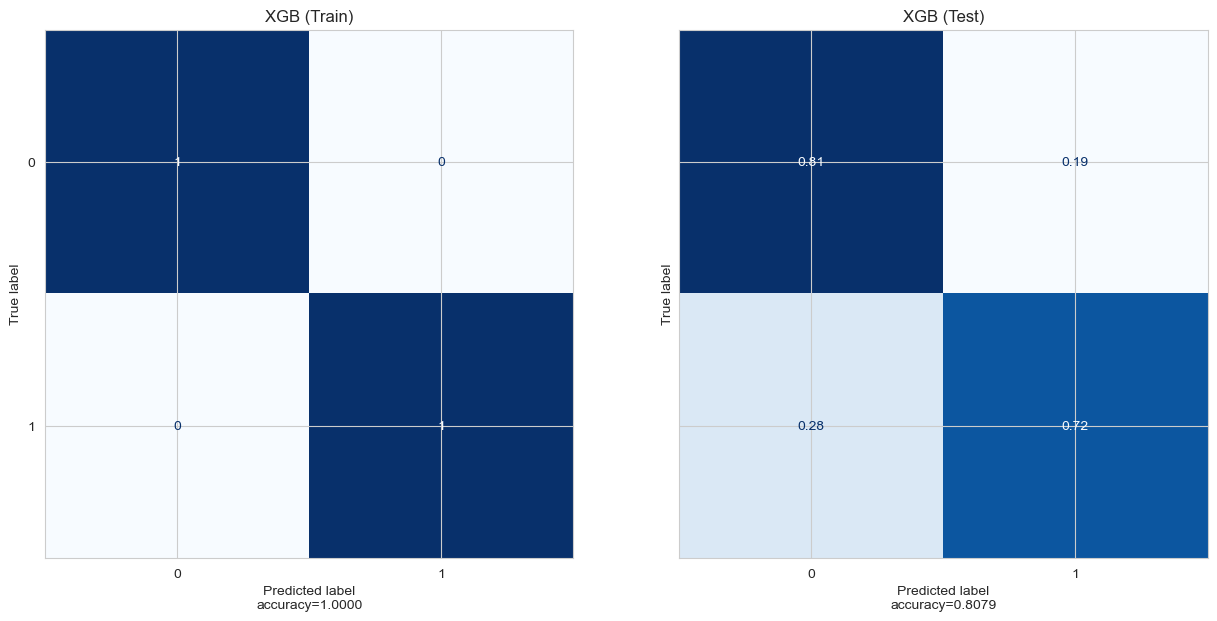

-----------MODELS COMPARISON--------- 



,Name,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Sensitivity (train),Sensitivity (test),Training time (s)
0,XGB,0.615402,1.000000,0.807893,0.384598,0.192107,1.000000,0.71875,0.039215
1,RF,0.675862,0.939189,0.917454,0.263327,0.021735,0.878378,0.65625,0.206038
2,GB,0.642529,0.993243,0.857533,0.350715,0.135710,0.986486,0.65625,0.051310
3,DT,0.714483,0.851351,0.952234,0.136869,0.100883,0.756757,0.62500,0.000000
4,ET,0.628506,1.000000,0.856542,0.371494,0.143458,1.000000,0.62500,0.245858
5,LR,0.147356,0.628378,0.678733,0.481022,0.050355,0.540541,0.59375,0.000000
6,ADA,0.662069,0.979730,0.768133,0.317661,0.211597,0.959459,0.59375,0.055656
7,MLP,0.430575,0.777027,0.753621,0.346452,0.023406,0.675676,0.53125,0.675038



-------------VIZUALIZATION----------- 



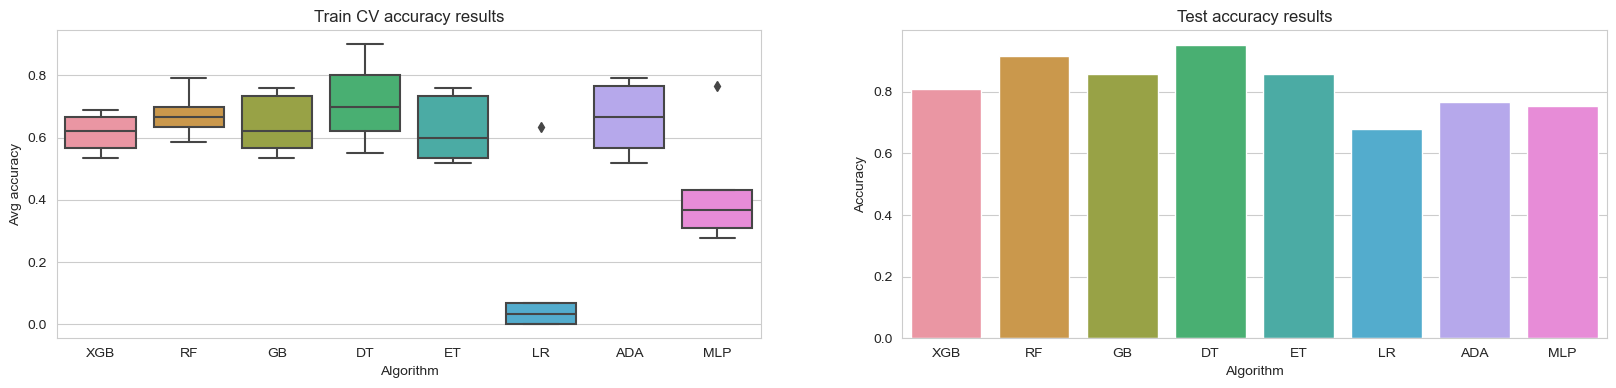

In [104]:
a,b = models_score(models, X_under, y_under, X_test, y_test, scoring = 'accuracy', n_splits=5)

## 6.3 SMOTE

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

----------------RESULTS-------------- 

Best accuracy in train (CV mean): 0.71
Best accuracy in test: 0.95
Best sensitivity in test: 0.72 


-------------BEST CONFUSION MATRIX (SENSITIVITY TEST)----------- 



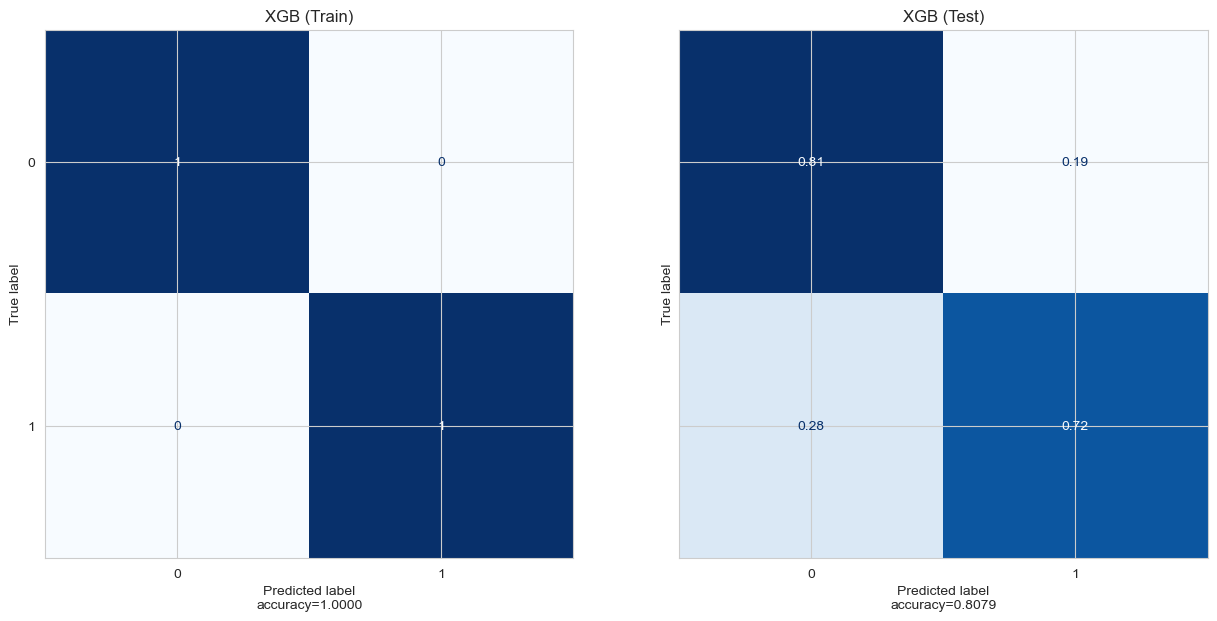

-----------MODELS COMPARISON--------- 



,Name,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Sensitivity (train),Sensitivity (test),Training time (s)
0,XGB,0.615402,1.000000,0.807893,0.384598,0.192107,1.000000,0.71875,0.059490
1,RF,0.675862,0.939189,0.917454,0.263327,0.021735,0.878378,0.65625,0.274691
2,GB,0.642529,0.993243,0.857533,0.350715,0.135710,0.986486,0.65625,0.046957
3,DT,0.714483,0.851351,0.952234,0.136869,0.100883,0.756757,0.62500,0.000000
4,ET,0.628506,1.000000,0.856542,0.371494,0.143458,1.000000,0.62500,0.233932
5,LR,0.147356,0.628378,0.678733,0.481022,0.050355,0.540541,0.59375,0.000000
6,ADA,0.662069,0.979730,0.768133,0.317661,0.211597,0.959459,0.59375,0.060850
7,MLP,0.430575,0.777027,0.753621,0.346452,0.023406,0.675676,0.53125,0.750758



-------------VIZUALIZATION----------- 



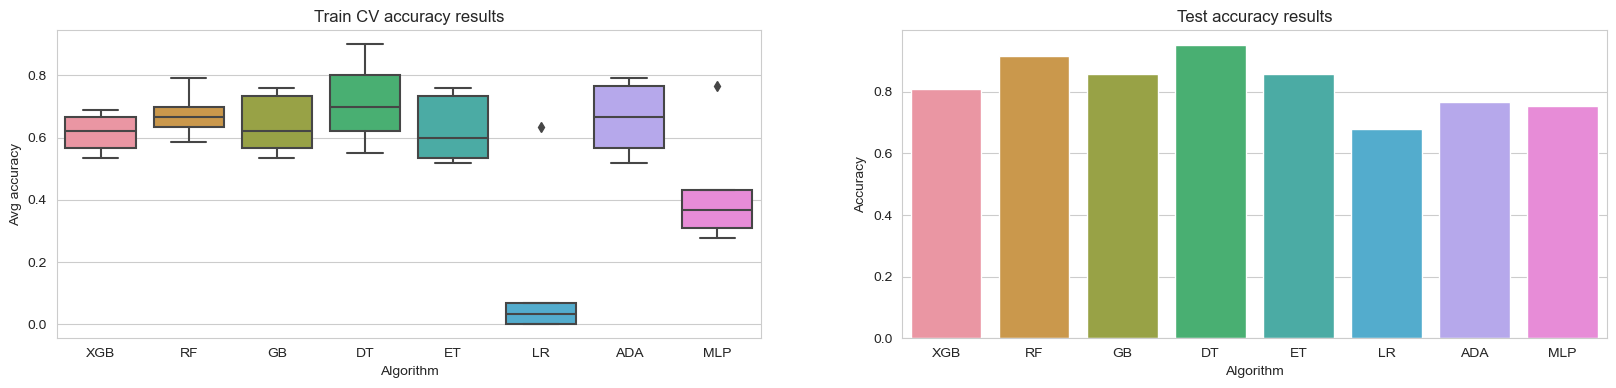

In [106]:
a,b = models_score(models, X_smote, y_smote, X_test, y_test, scoring = 'accuracy', n_splits=5)

### O undersampling e o SMOTE tiveram resultados bem semelhantes, porém o SMOTE por criar perturbações na base acaba sendo uma solução mais delicada, pois pode gerar inconsistências na base. 
### Optamos assim por seguir com o Undersampling.

## 7. Análise do melhor cenário

### 7.1 Random Forest

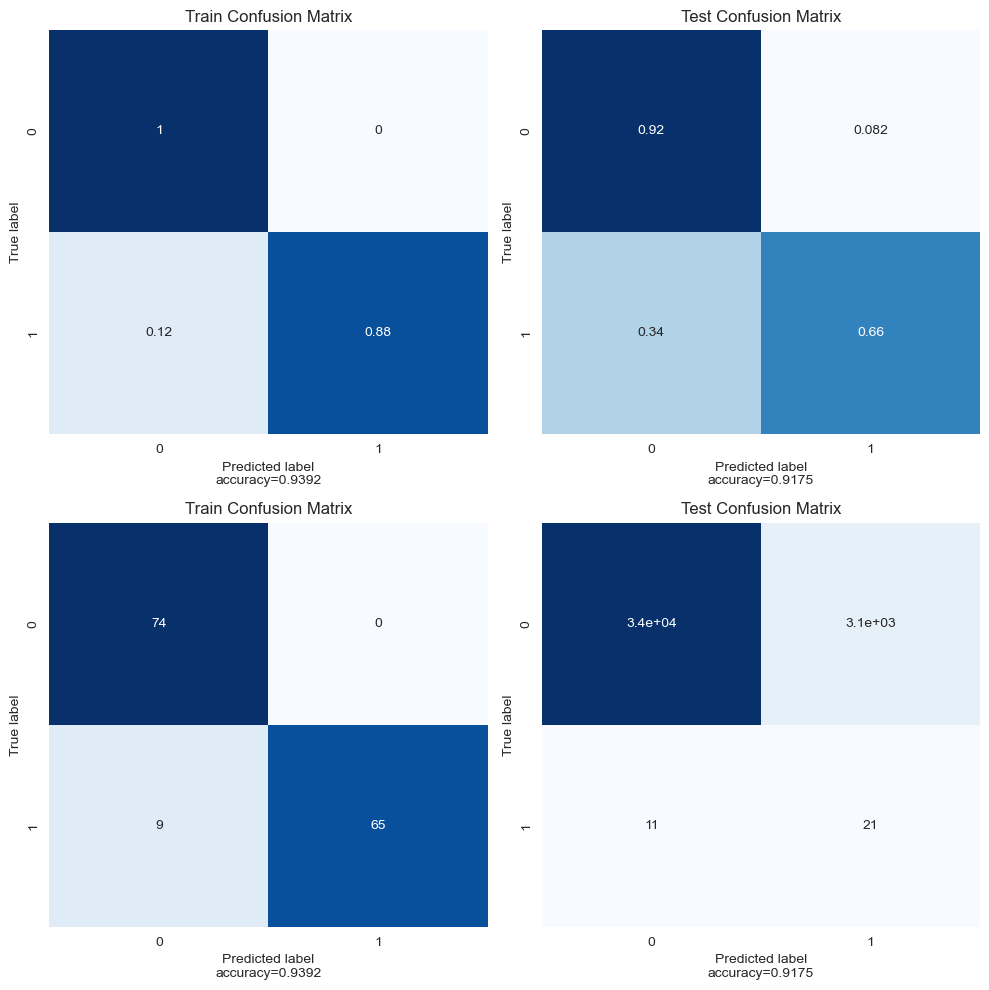

In [105]:
rf_clf = RandomForestClassifier(random_state=seed, max_depth = 7, n_jobs=4)
rf_clf.fit(X_under, y_under)
plot_confusion_matrix(y_under, y_test, X_under, X_test, rf_clf)

In [108]:
d = {'Feature':X_train.columns,'Importance':rf_clf.feature_importances_.tolist()} 
df_explic = pd.DataFrame(d, columns=['Feature','Importance'])
df_explic['Importance'] = df_explic['Importance']
df_explic.sort_values(by='Importance', ascending=False)

,Feature,Importance
3,attribute4,0.201679
1,attribute2,0.179685
5,attribute6,0.173267
6,attribute7,0.149944
0,attribute1,0.144128
4,attribute5,0.091879
7,attribute9,0.042197
2,attribute3,0.017221


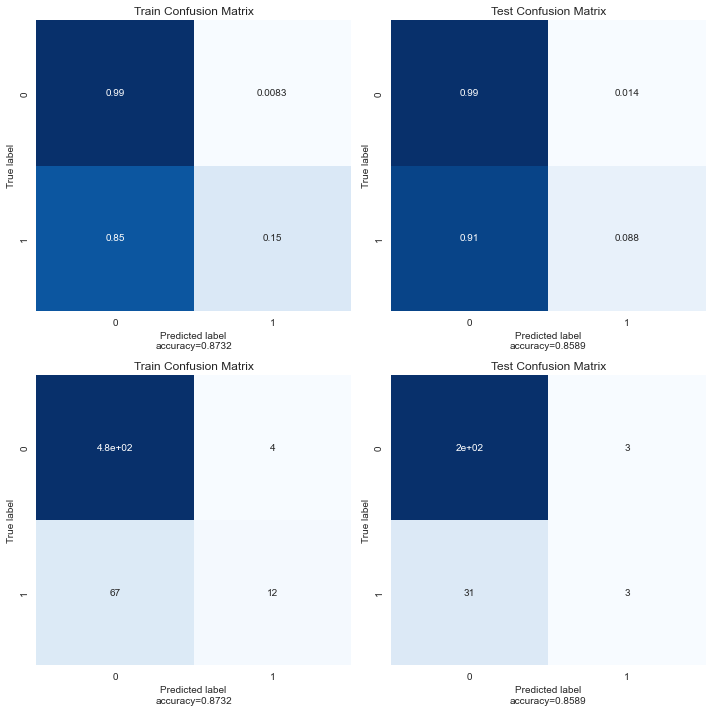

In [61]:
xgb_clf = XGBClassifier(random_state=seed, eval_metric='logloss', n_jobs=-1, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)
plot_confusion_matrix(y_train, y_test, X_train, X_test, xgb_clf)

In [62]:
d = {'Feature':X_train.columns,'Importance':xgb_clf.feature_importances_.tolist()} 
df_explic = pd.DataFrame(d, columns=['Feature','Importance'])
df_explic['Importance'] = df_explic['Importance']
df_explic.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,Flag 3 - Cidade Serasa,0.349879
3,Flag 6 - CEP OiID,0.201743
5,Flag 17 - CPFs mesmo END,0.144107
7,Flag 23,0.116589
17,Flag 11 - CPF Serasa,0.040487
1,Flag 2 - UF Serasa,0.035559
0,Flag 1 - Nome Serasa,0.031166
16,Flag 15 - CPF Receita,0.031102
6,Flag 22 - CPF dif Cartões,0.030897
15,Flag 14 - Situação Cadastral Receita,0.018471


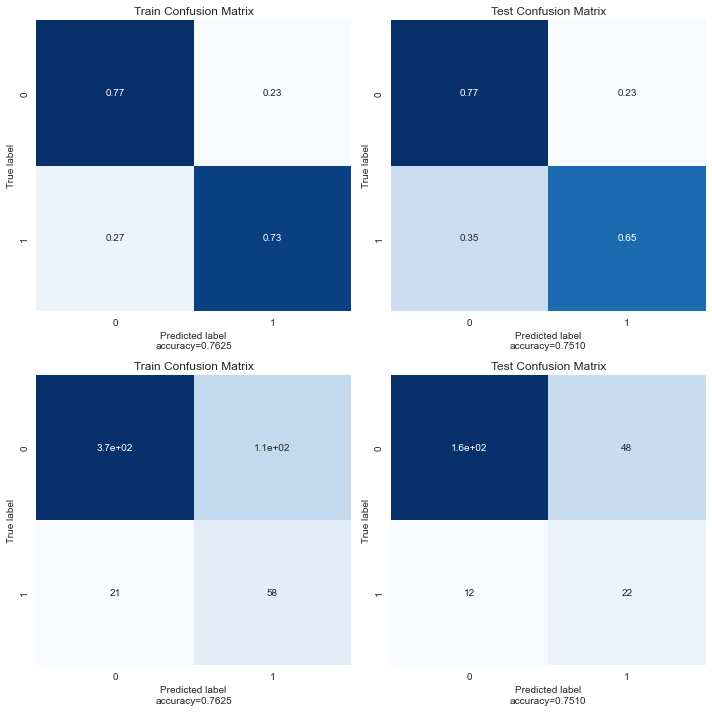

In [97]:
xgb_clf = XGBClassifier(random_state=seed, eval_metric='logloss', n_jobs=-1, use_label_encoder=False,scale_pos_weight=6.08)
xgb_clf.fit(X_train, y_train)
plot_confusion_matrix(y_train, y_test, X_train, X_test, xgb_clf)

In [98]:
d = {'Feature':X_train.columns,'Importance':xgb_clf.feature_importances_.tolist()} 
df_explic = pd.DataFrame(d, columns=['Feature','Importance'])
df_explic['Importance'] = df_explic['Importance']
df_explic.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,Flag 3 - Cidade Serasa,0.277398
14,Flag 25.i - Não Certificado,0.240506
3,Flag 6 - CEP OiID,0.197844
17,Flag 11 - CPF Serasa,0.093870
5,Flag 17 - CPFs mesmo END,0.048147
16,Flag 15 - CPF Receita,0.038204
1,Flag 2 - UF Serasa,0.030450
6,Flag 22 - CPF dif Cartões,0.025252
0,Flag 1 - Nome Serasa,0.019415
15,Flag 14 - Situação Cadastral Receita,0.011744


In [109]:
scores = cross_validate(rf_clf, X_under, y_under, cv=5, scoring=('accuracy', 'recall', 'precision'), return_train_score=True)

print('RF: ')
print("Acc train: %.2f%% (%.2f%%)" % (scores['train_accuracy'].mean()*100, scores['train_accuracy'].std()*100))
print("Acc test: %.2f%% (%.2f%%)" % (scores['test_accuracy'].mean()*100, scores['test_accuracy'].std()*100))
print("Rec train: %.2f%% (%.2f%%)" % (scores['train_recall'].mean()*100, scores['train_recall'].std()*100))
print("Rec test: %.2f%% (%.2f%%)" % (scores['test_recall'].mean()*100, scores['test_recall'].std()*100))
print("Prec train: %.2f%% (%.2f%%)" % (scores['train_precision'].mean()*100, scores['train_precision'].std()*100))
print("Prec test: %.2f%% (%.2f%%)" % (scores['test_precision'].mean()*100, scores['test_precision'].std()*100))

RF: 
Acc train: 95.27% (1.56%)
Acc test: 76.46% (10.68%)
Rec train: 90.54% (3.14%)
Rec test: 71.52% (15.05%)
Prec train: 100.00% (0.00%)
Prec test: 79.30% (9.93%)


In [113]:
param_dist = {'max_depth': [5,6,7,8,9,10,11,12,13,14,15],
              'n_estimators':[80,100,150,250,500],
              'ccp_alpha': [0,0.5,1,1.5,2],
              'max_features': ["sqrt", "log2"],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2]
             } 

In [114]:
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=500, n_jobs = 4, cv = 5, scoring = 'f1', verbose=3)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=7, n_jobs=4,
                                                    random_state=42),
                   n_iter=500, n_jobs=4,
                   param_distributions={'ccp_alpha': [0, 0.5, 1, 1.5, 2],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [80, 100, 150, 250,
                                                         500]},
                   scoring='f1', verbose=3)

In [116]:
best_params = random_search.best_params_
best_params

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 12,
 'ccp_alpha': 0}

## 7. Análise de decis

In [117]:
data['prob'] = rf_clf.predict_proba(data[list(X_train.columns)])[:,1]

In [118]:
df_ks = ks(type = 'treino', data=data,target='failure', prob="prob")

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.474878,1.000000,89.0,12361.0,83.96%,9.94%,83.96%,9.94%,74.0
2,0.391329,0.474878,7.0,12442.0,6.60%,10.00%,90.57%,19.94%,70.6
3,0.337463,0.391329,3.0,12446.0,2.83%,10.01%,93.40%,29.95%,63.5
4,0.295058,0.337463,1.0,12449.0,0.94%,10.01%,94.34%,39.95%,54.4
5,0.259888,0.295054,2.0,12447.0,1.89%,10.01%,96.23%,49.96%,46.3
6,0.225550,0.259886,2.0,12447.0,1.89%,10.01%,98.11%,59.97%,38.1
7,0.191318,0.225541,0.0,12450.0,0.00%,10.01%,98.11%,69.98%,28.1
8,0.150750,0.191318,2.0,12447.0,1.89%,10.01%,100.00%,79.98%,20.0
9,0.117127,0.150736,0.0,12449.0,0.00%,10.01%,100.00%,89.99%,10.0


KS is 74.0% at decile 1


### 7.3 Modelo treinado

In [111]:
import pickle
# salvando o modelo final
pkl_filename = "mvp_fraude_xgb.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_clf, file)